# 『ゼロから始めるDeepLeaning』7章：畳み込みニューラルネットワーク(CNN)

今回用いるファイルは

mnist.py,simple_convnet.py,trainer.py,collections.py,im2col.py,layers.py,optimizer.py

になります．

## 講義の流れ

### 0.深層にするには？

### 1.畳み込み層，プーリング層の理解

### 2.畳み込み層とプーリング層の実装

### 3.代表的なCNNの紹介とアーキテクチャの見方


In [62]:
# coding: utf-8
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict # Pythonの順序付き辞書型を扱うためのライブラリ

plt.style.use('ggplot')

## 0.深層にするには？

### 導入
ニューラルネットワークを勉強し，実装に関するテクニックを学んできました．

ここで，深層学習と言うからには層を深くしていきたいというのが自然な発想です．

しかし，層を深くしていくと，勾配消失，爆発などの問題が発生してしまいます．

具体的に実装してみましょう．

/home/taichi/anaconda3/lib/python3.10/site-packages/sklearn/datasets/_openml.py:932: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(
/home/taichi/anaconda3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/taichi/anaconda3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/taichi/anaconda3/lib/python3.10/site-packages

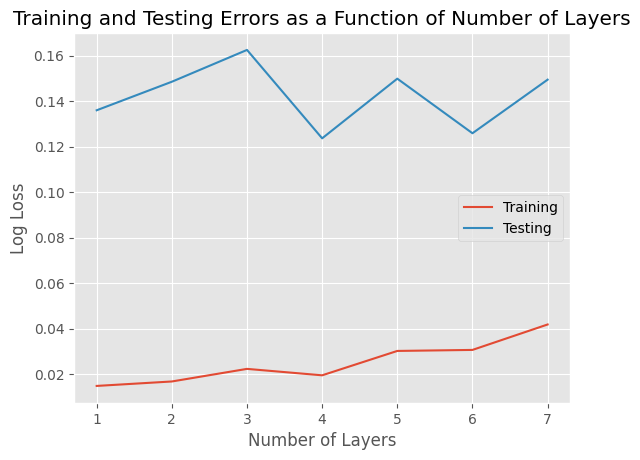

In [63]:
from sklearn.datasets import fetch_openml
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt

# Load MNIST dataset
X, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)

# Normalize inputs from 0-255 to 0-1
X = X / 255.

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# List to store training and testing errors
training_errors = []
testing_errors = []

# Number of layers to test

#layers = [(50,), (50, 50), (50, 50, 50), (50, 50, 50, 50), (50, 50, 50, 50, 50)] # 1~5層

layers = [(50,), (50, 50), (50, 50, 50), (50, 50, 50, 50), (50, 50, 50, 50, 50),
          (50, 50, 50, 50, 50, 50), (50, 50, 50, 50, 50, 50, 50)] # 1 ~ 7層




for layer in layers:
    mlp = MLPClassifier(hidden_layer_sizes=layer, max_iter=20, alpha=1e-4,
                        solver='sgd', verbose=0, random_state=1,
                        learning_rate_init=.1)
    mlp.fit(X_train, y_train)
    training_errors.append(log_loss(y_train, mlp.predict_proba(X_train)))
    testing_errors.append(log_loss(y_test, mlp.predict_proba(X_test)))

# Plot training and testing errors
plt.plot([len(layer) for layer in layers], training_errors, label='Training')
plt.plot([len(layer) for layer in layers], testing_errors, label='Testing')

plt.title('Training and Testing Errors as a Function of Number of Layers')
plt.xlabel('Number of Layers')
plt.ylabel('Log Loss')
plt.legend()
plt.show()


上の結果からわかるように，ニューラルネットの層を深くしても精度があがりません．

$\textbf{それどころか，層を深くすると，学習がうまくいかないこともあります．}$

ではなぜ，深層学習が流行っているのでしょうか？

もちろん，工夫をすることで深層にし学習がうまく行くようになっているからなのですが，その工夫とはなんでしょうか？

今回の章では，画像分類で成功を収め，深層学習の火付け役となった畳み込みニューラルネットワーク（CNN）について学んでいきます．


題目にある畳み込みニューラルネットワーク(CNN)は，これまで学習してきた全結合層(Affine)のニューラルネットワークを工夫したものになっています．

もともと全結合層には以下の欠点がありました．

#### 1.層を増やしたり入力次元を増やしたりすると，それに伴ってパラメータが爆発的に増えてしまう．（それに伴い学習が困難になる）

#### 2.入力データの次元を変えられない．

これらを解消するために開発されたのが畳み込み演算を用いたニューラルネットワークになります．







## 1.畳み込み層，プーリング層の理解
講義内で白板を持ちいて説明します．以下では，必要になる結果の抜粋をします．

### 畳み込み層の定義
畳み込み層は，入力データに対してフィルター演算を行う層です．
$$
u_{i,j}^{(k)} = \sum_{m=0}^{M-1}\sum_{n=0}^{N-1}x_{i+m,j+n}^{(k-1)}w_{m,n}^{(k)} + b^{(k)}
$$
ここで$M$は 縦方向のフィルターのサイズ，$N$は横方向のフィルターのサイズ，$b^{(k)}$はバイアス，$w_{m,n}^{(k)}$はフィルターの重み，$x_{i+m,j+n}^{(k-1)}$は入力データの$i+m$行$j+n$列の要素を表します．

### 出力サイズの確認
$$
O = \lfloor \frac{I + 2P - K}{S} \rfloor+1\\
$$
$O:出力サイズ，I:入力サイズ，P:パディングサイズ，K:フィルターサイズ$

# 2.畳み込み層とプーリング層の実装
### 見慣れないメソッドの解説

#### np.pad
配列の周囲に要素を追加するメソッドです．

`puts 'np.pad(array, pad_width, mode='constant', **kwargs)'` 

引数の説明:

array: パディングする配列です。

pad_width: パディングの量を指定するパラメータです。次元ごとにパディングの前後の要素数を指定するタプルで表現されます。

mode: パディングの方法を指定するパラメータです。デフォルトは 'constant' です。他のオプションとしては、'edge'、'maximum'、'minimum'、'reflect'、'symmetric'などがあります。

In [64]:
import numpy as np

arr = np.array([[1, 2, 3], [4, 5, 6]])
print(arr)

[[1 2 3]
 [4 5 6]]


In [65]:
padded = np.pad(arr, ((3, 2), (1, 4)), mode='constant')
print(padded)

[[0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 1 2 3 0 0 0 0]
 [0 4 5 6 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]]


#### np.transpose
配列の軸を入れ替えるメソッドです．

`puts 'np.transpose(a, axes=None)'`

In [66]:
import numpy as np
'''
(2,2,2)の形状の配列を作成する
今回はtransposeメソッドを使って、1番目と2番めの軸を入れ替えます．
'''

arr = np.array([[[1, 2], 
                 [3, 4]], 
                 [[5, 6], 
                  [7, 8]]])
print(arr)

[[[1 2]
  [3 4]]

 [[5 6]
  [7 8]]]


In [67]:
arr[0 , 1]

array([3, 4])

In [68]:
transposed = arr.transpose((0, 2, 1))
print(transposed)

[[[1 3]
  [2 4]]

 [[5 7]
  [6 8]]]


#### reshape(-1)
配列の形状を変更するメソッドです．

`puts 'reshape(shape, order='C')'`

In [69]:
import numpy as np

arr = np.array([[1, 2, 3], [4, 5, 6]])
arr

array([[1, 2, 3],
       [4, 5, 6]])

In [70]:
#　もちろんエラーがおきます
reshaped = arr.reshape(1)

ValueError: cannot reshape array of size 6 into shape (1,)

In [71]:
# 配列の次元を落とす．
reshaped = arr.reshape(-1)
reshaped

array([1, 2, 3, 4, 5, 6])

In [72]:
# 3次元配列の場合
import numpy as np

# 3次元配列の定義
arr_3d = np.array([[[1, 2, 3], [4, 5, 6]], [[7, 8, 9], [10, 11, 12]]])

# 3次元配列を2次元配列に変換
arr_2d = arr_3d.reshape(-1, arr_3d.shape[-1])

# 結果を表示
print("3次元配列:\n", arr_3d)
print("2次元配列:\n", arr_2d)


3次元配列:
 [[[ 1  2  3]
  [ 4  5  6]]

 [[ 7  8  9]
  [10 11 12]]]
2次元配列:
 [[ 1  2  3]
 [ 4  5  6]
 [ 7  8  9]
 [10 11 12]]


### 入力するデータ：4次元配列
(データ数，チャンネル数，高さ，幅)の形状を持つ4次元配列を入力します．



In [73]:
import numpy as np

# 入力データの形状を指定
batch_size = 2 # バッチサイズ
channel_num = 3 # チャンネル数
height = 4 # 高さ
width = 5 # 幅

# 入力データを作成
input_data = np.random.rand(batch_size, channel_num, height, width)

# 入力データの形状を表示
print("入力データの形状:", input_data.shape)


入力データの形状: (2, 3, 4, 5)


In [74]:
print("入力データ:\n", input_data)

入力データ:
 [[[[0.82076712 0.90884372 0.81552382 0.15941446 0.62889844]
   [0.39843426 0.06271295 0.42403225 0.25868407 0.84903831]
   [0.03330463 0.95898272 0.35536885 0.35670689 0.0163285 ]
   [0.18523233 0.4012595  0.92929142 0.09961493 0.94530153]]

  [[0.86948853 0.4541624  0.32670088 0.23274413 0.61446471]
   [0.03307459 0.01560606 0.42879572 0.06807407 0.25194099]
   [0.22116092 0.25319119 0.13105523 0.01203622 0.1154843 ]
   [0.61848026 0.97425621 0.990345   0.4090541  0.16295443]]

  [[0.63876176 0.49030535 0.98940978 0.06530421 0.78323444]
   [0.2883985  0.24141862 0.66250457 0.24606318 0.66585912]
   [0.51730852 0.42408899 0.55468781 0.28705152 0.70657471]
   [0.41485687 0.36054556 0.82865691 0.92496691 0.04600731]]]


 [[[0.23262699 0.34851937 0.81496648 0.98549143 0.9689717 ]
   [0.90494835 0.29655627 0.99201124 0.24942004 0.10590615]
   [0.95095261 0.23342026 0.68976827 0.05835636 0.7307091 ]
   [0.88172021 0.2724369  0.3790569  0.37429618 0.74878826]]

  [[0.23780724 0.17185

## im2col(image to column)
参考：https://qiita.com/kuroitu/items/35d7b5a4bde470f69570

https://www.youtube.com/watch?v=9s83xaQzAuA

ここからは画像データを行列に変換する関数『im2col』を学びます．

畳み込みの実装は，真面目にやるとfor文を繰り返し使用することになります．

これは面倒であると同時に，Numpyとfor文との相性が悪い（計算に時間がかかる）ため処理が遅くなる欠点があります．

そこでim2colという便利な関数を用いたシンプルな実装を行います．

まずは理解のために簡単な例で実装をしましょう．
$$
\begin{bmatrix}
1 & 2 & 3 & 0 \\
0 & 1 & 2 & 3 \\
3 & 0 & 1 & 2 \\
2 & 3 & 0 & 1 \\
\end{bmatrix}
\ast
\begin{bmatrix}
2 & 0 & 1 \\
0 & 1 & 2 \\
1 & 0 & 2 \\
\end{bmatrix}
=
\begin{bmatrix}
a & b \\
c & d \\
\end{bmatrix}
$$
という畳み込み計算を実装します．

これは内積の形で以下のように書けます
$$
\begin{bmatrix}
2 & 0 & 1 & 0 & 1 & 2 & 1 & 0 & 2\\
\end{bmatrix}
・
\begin{bmatrix}
1 & 2 & 0&1\\
2 & 3 & 1&2\\
3 & 0 & 2&3\\
0 & 1 & 3&0\\
1 & 2 & 0&1\\
2 & 3 & 1&2\\
3 & 0 & 2&3\\
0 & 1 & 3&0\\
1 & 2 & 0&1\\
\end{bmatrix}
=
\begin{bmatrix}
a & b & c & d \\
\end{bmatrix}
$$

この計算における左辺の右側
$$
\begin{bmatrix}
1 & 2 & 0&1\\
2 & 3 & 1&2\\
3 & 0 & 2&3\\
0 & 1 & 3&0\\
1 & 2 & 0&1\\
2 & 3 & 1&2\\
3 & 0 & 2&3\\
0 & 1 & 3&0\\
1 & 2 & 0&1\\
\end{bmatrix}
$$
をim2colは作成します．

In [75]:
import numpy as np

In [76]:
# 入力データ
x = np.array([[1,2,3,0],
              [0,1,2,3],
              [3,0,1,2],
              [2,3,0,1]])
x

array([[1, 2, 3, 0],
       [0, 1, 2, 3],
       [3, 0, 1, 2],
       [2, 3, 0, 1]])

In [77]:
# カーネル
k = np.array([[2,0,1],
              [0,1,2],
              [1,0,2]])
k

array([[2, 0, 1],
       [0, 1, 2],
       [1, 0, 2]])

In [78]:
# アウトプットサイズの計算を行う関数
def output_size(input_size, filter_size, stride=1, pad=0):
    return (input_size + 2*pad - filter_size) / stride + 1

In [79]:
o = output_size(len(x) , len(k) , stride=1, pad=0)
o = int(o)

In [80]:
x_col = np.zeros((len(k)*len(k) , o*o))
x_col

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

In [81]:
'''
実際にim2colを行う関数を作成する
ここでアウトプット分回すので，先程その回数を計算しておきました．
'''
def im2col(x , fil_size , output_size):
    x_col = np.zeros((fil_size*fil_size , output_size*output_size))
    for i in range(output_size):
        for j in range(output_size):
            x_col[: , i*output_size+j] = x[i:i+fil_size , j:j+fil_size].reshape(-1)
    return x_col

作りたかったのは以下のような行列です．
$$
\begin{bmatrix}
1 & 2 & 0&1\\
2 & 3 & 1&2\\
3 & 0 & 2&3\\
0 & 1 & 3&0\\
1 & 2 & 0&1\\
2 & 3 & 1&2\\
3 & 0 & 2&3\\
0 & 1 & 3&0\\
1 & 2 & 0&1\\
\end{bmatrix}
$$

In [82]:
im2col(x , len(k) , o)

array([[1., 2., 0., 1.],
       [2., 3., 1., 2.],
       [3., 0., 2., 3.],
       [0., 1., 3., 0.],
       [1., 2., 0., 1.],
       [2., 3., 1., 2.],
       [3., 0., 2., 3.],
       [0., 1., 3., 0.],
       [1., 2., 0., 1.]])

以上の様にim2colとは，フィルターにとって都合の良いように入力データを展開する関数になります．

教科書ではブラックボックスで使用することを想定していますが，教科書で想定されているim2col関数を以下に示しておきます．また，im2col.pyに同様のコードがありますので必要に応じて参照してください．



In [83]:
# 画像から行列への変換．
def im2col(input_data, filter_h, filter_w, stride=1, pad=0):
    """

    Parameters
    ----------
    input_data : (データ数, チャンネル, 高さ, 幅)の4次元配列からなる入力データ
    filter_h : フィルターの高さ
    filter_w : フィルターの幅
    stride : ストライド
    pad : パディング

    Returns
    -------
    col : 2次元配列
    """
    N, C, H, W = input_data.shape
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1

    # numpy.padでパディングを簡単に行うことができる
    img = np.pad(input_data, [(0,0), (0,0), (pad, pad), (pad, pad)], 'constant')
    col = np.zeros((N, C, filter_h, filter_w, out_h, out_w))

    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            col[:, :, y, x, :, :] = img[:, :, y:y_max:stride, x:x_max:stride]

    '''
    チャンネルを軸にして入れ替える
    tranposeメソッドにより，col配列の軸の順序が(データ数, out_h, out_w, チャンネル, filter_h, filter_w)になる
    reshapeメソッドにより，(データ数, out_h, out_w, チャンネル, filter_h, filter_w)を(データ数*out_h*out_w, チャンネル*filter_h*filter_w)に変換する
    '''
    col = col.transpose(0, 4, 5, 1, 2, 3).reshape(N*out_h*out_w, -1)
    return col

実際に実行をしてみましょう．

入力には(バッチサイズ , チャンネル数 , 縦 , 横)という情報を含み，

im2colの引数は(入力データ，フィルターサイズ縦 , フィルターサイズ横 , ストライド幅 , パディングサイズ)という具合になっています．

以下では2つの例を示しています．

In [84]:
x1 = np.random.rand(1, 3, 7, 7) # 入力データ
col1 = im2col(x1, 5, 5, stride=1, pad=0)
print(col1.shape) # (9, 75)

x2 = np.random.rand(10, 3, 7, 7) # 10個のデータ
col2 = im2col(x2, 5, 5, stride=1, pad=0)
print(col2.shape) # (90, 75)

(9, 75)
(90, 75)


出力は
$$
（アウトプットサイズの積　，チャンネル数×フィルターサイズの積）
$$
になるはずです．

以上が畳み込み計算を効率良く行うための基本的な関数であるim2colの説明でした．

## 畳み込み層(Convolution layer)の実装

ここからは畳み込み層の実装に入ります．

引数として，カーネルの情報を必要とします．具体的には，
$$
カーネル各要素値，バイアス，ストライド幅，パディングサイズ
$$
です．

その後，先程作成したim2col関数を用いて畳み込み演算を行い，バイアス項を付けて出力値を得ます．

In [85]:
class Convolution:
    '''
    Wには(バッチサイズ，チャンネル数，フィルターの高さ，フィルターの幅)の4次元配列が入る
    stride=1 , pad=0としているので，インスタンス化の際に引数を省略した場合は，stride=1 , pad=0となる．
    '''
    def __init__(self , W , b , stride=1 , pad=0):
        self.W = W
        self.b = b
        self.stride = stride
        self.pad = pad
    
    def forward(self , x):
        FN , C , FH , FW = self.W.shape
        N , C , H , W = x.shape
        out_h = int(1 + (H + 2*self.pad - FH)/self.stride)
        out_w = int(1 + (W + 2*self.pad - FW)/self.stride)

        col = im2col(x , FH , FW , self.stride , self.pad)
        col_W = self.W.reshape(FN , -1).T
        out = np.dot(col , col_W) + self.b
    #  出力値は(バッチサイズ，高さ，幅，チャンネル数)となっているため，（バッチサイズ，チャンネル，高さ，幅）と変更
        out = out.reshape(N , out_h , out_w , -1).transpose(0 , 3 , 1 , 2)
        
        return out

この様にim2colを用いてあげれば，内積の形で畳み込みができたことを思い出すと理解できるように，全結合層と同じ様に実装が可能です．

誤差逆伝搬も含めた実装は以下のようになります．

In [86]:
import numpy as np

# クラス定義
class Convolution:
    def __init__(self, W, b, stride=1, pad=0):
        self.W = W
        self.b = b
        self.stride = stride
        self.pad = pad

        self.x = None
        self.col = None
        self.col_W = None

        self.dW = None
        self.db = None

    # 順伝播
    def forward(self, x):
        FN, C, FH, FW = self.W.shape
        N, C, H, W = x.shape
        out_h = 1 + int((H + 2*self.pad - FH) / self.stride)
        out_w = 1 + int((W + 2*self.pad - FW) / self.stride)

        col = self.im2col(x, FH, FW)
        col_W = self.W.reshape(FN, -1).T

        out = np.dot(col, col_W) + self.b
        out = out.reshape(N, out_h, out_w, -1).transpose(0, 3, 1, 2)

        self.x = x
        self.col = col
        self.col_W = col_W

        return out
    
    # 逆伝播
    def backward(self, dout):
        FN, C, FH, FW = self.W.shape
        dout = dout.transpose(0, 2, 3, 1).reshape(-1, FN)

        self.db = np.sum(dout, axis=0)
        self.dW = np.dot(self.col.T, dout)
        self.dW = self.dW.transpose(1, 0).reshape(FN, C, FH, FW)

        dcol = np.dot(dout, self.col_W.T)
        dx = self.col2im(dcol, self.x.shape)

        return dx
    
    # im2col
    def im2col(self, input_data, filter_h, filter_w):
        N, C, H, W = input_data.shape
        out_h = (H + 2*self.pad - filter_h) // self.stride + 1
        out_w = (W + 2*self.pad - filter_w) // self.stride + 1

        img = np.pad(input_data, [(0,0), (0,0), (self.pad, self.pad), (self.pad, self.pad)], 'constant')
        col = np.zeros((N, C, filter_h, filter_w, out_h, out_w))

        for y in range(filter_h):
            y_max = y + self.stride * out_h
            for x in range(filter_w):
                x_max = x + self.stride * out_w
                col[:, :, y, x, :, :] = img[:, :, y:y_max:self.stride, x:x_max:self.stride]

        col = col.transpose(0, 4, 5, 1, 2, 3).reshape(N*out_h*out_w, -1)
        return col
    
    # col2im
    def col2im(self, col, input_shape):
        N, C, H, W = input_shape
        out_h = (H + 2*self.pad - self.W.shape[2]) // self.stride + 1
        out_w = (W + 2*self.pad - self.W.shape[3]) // self.stride + 1
        col = col.reshape(N, out_h, out_w, C, self.W.shape[2], self.W.shape[3]).transpose(0, 3, 4, 5, 1, 2)

        img = np.zeros((N, C, H + 2*self.pad + self.stride - 1, W + 2*self.pad + self.stride - 1))
        for y in range(self.W.shape[2]):
            y_max = y + self.stride*out_h
            for x in range(self.W.shape[3]):
                x_max = x + self.stride*out_w
                img[:, :, y:y_max:self.stride, x:x_max:self.stride] += col[:, :, y, x, :, :]

        return img[:, :, self.pad:H + self.pad, self.pad:W + self.pad]



In [87]:
# 乱数のシードを設定
np.random.seed(0)

# テストデータ
x = np.random.rand(2, 3, 4, 4)  # (データ数, チャンネル数, 高さ, 幅)
W = np.random.rand(3, 3, 3, 3)  # (フィルター数, チャンネル数, フィルターの高さ, フィルターの幅)
b = np.random.rand(3)  # (フィルター数,)

# インスタンス化
conv = Convolution(W, b, stride=2, pad=1)

# 順伝播
out = conv.forward(x)
print("順伝播出力:\n", out.shape)

# 逆伝播
dout = np.random.rand(*out.shape)  # 順伝播出力と同じ形状の勾配
dx = conv.backward(dout)
print("逆伝播出力:\n", dx.shape)


順伝播出力:
 (2, 3, 2, 2)
逆伝播出力:
 (2, 3, 4, 4)


## プーリング層(Pooling layer)の実装

続いてプーリング層の実装に移ります．

教科書ではいわゆるMaxPoolingの説明をしています．

カーネルサイズの範囲で最大値を返すこと以外は，畳み込み層の実装と大差はありませんので実際のclassを以下に示しておきます．

In [92]:
import numpy as np

class Pooling:
    def __init__(self, pool_h, pool_w, stride=1, pad=0):
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.stride = stride
        self.pad = pad

        self.x = None
        self.arg_max = None

    def forward(self, x):
        N, C, H, W = x.shape
        out_h = int(1 + (H - self.pool_h) / self.stride)
        out_w = int(1 + (W - self.pool_w) / self.stride)

        col = self.im2col(x, self.pool_h, self.pool_w, self.stride, self.pad)
        col = col.reshape(-1, self.pool_h*self.pool_w)
        
        arg_max = np.argmax(col, axis=1)
        out = np.max(col, axis=1)

        out = out.reshape(N, out_h, out_w, C).transpose(0, 3, 1, 2)

        self.x = x
        self.arg_max = arg_max

        return out

    def backward(self, dout):
        dout = dout.transpose(0, 2, 3, 1)

        pool_size = self.pool_h * self.pool_w
        dmax = np.zeros((dout.size, pool_size))
        dmax[np.arange(self.arg_max.size), self.arg_max.flatten()] = dout.flatten()
        dmax = dmax.reshape(dout.shape + (pool_size,))

        dcol = dmax.reshape(dmax.shape[0] * dmax.shape[1] * dmax.shape[2], -1)
        dx = self.col2im(dcol, self.x.shape)

        return dx

    def im2col(self, input_data, filter_h, filter_w, stride=1, pad=0):
        N, C, H, W = input_data.shape
        out_h = (H + 2 * pad - filter_h) // stride + 1
        out_w = (W + 2 * pad - filter_w) // stride + 1

        img = np.pad(input_data, [(0, 0), (0, 0), (pad, pad), (pad, pad)], 'constant')
        col = np.zeros((N, C, filter_h, filter_w, out_h, out_w))

        for y in range(filter_h):
            y_max = y + stride * out_h
            for x in range(filter_w):
                x_max = x + stride * out_w
                col[:, :, y, x, :, :] = img[:, :, y:y_max:stride, x:x_max:stride]

        col = col.transpose(0, 4, 5, 1, 2, 3).reshape(N * out_h * out_w, -1)
        return col

    def col2im(self, col, input_shape):
        N, C, H, W = input_shape
        out_h = (H - self.pool_h) // self.stride + 1
        out_w = (W - self.pool_w) // self.stride + 1
        col = col.reshape(N, out_h, out_w, C, self.pool_h, self.pool_w).transpose(0, 3, 4, 5, 1, 2)
        img = np.zeros((N, C, H, W))

        for y in range(self.pool_h):
            y_max = y + self.stride * out_h
            for x in range(self.pool_w):
                x_max = x + self.stride * out_w
                img[:, :, y:y_max:self.stride, x:x_max:self.stride] += col[:, :, y, x, :, :]

        return img



In [93]:
# 具体例
np.random.seed(0)

# テストデータ
x = np.random.rand(2, 3, 8, 8)  # (データ数, チャンネル数, 高さ, 幅)

# インスタンス化
pool = Pooling(pool_h=2, pool_w=2, stride=2)

# 順伝播
out = pool.forward(x)
print("順伝播出力:\n", out.shape)

# 逆伝播
dout = np.random.rand(*out.shape)  # 順伝播出力と同じ形状の勾配
dx = pool.backward(dout)
print("逆伝播出力:\n", dx.shape)


順伝播出力:
 (2, 3, 4, 4)
逆伝播出力:
 (2, 3, 8, 8)


## CNNの実装
Convolution層とPooling層を実装したので，いよいよ畳み込みニューラルネットワークの実装に移ります．

### アーキテクチャ(SimpleConvNet)
Convolution - ReLU - Pooling - Affine - ReLU - Affine - Softmax

### 引数
input_dim : 入力データの次元(チャンネル，高さ，幅)

conv_param : 畳み込み層のハイパーパラメータ

hidden_size : 隠れ層

output_size : 出力層

weight_init_std : 初期化時の標準偏差

In [95]:
from utils.layers import *
from utils.functions import *

class SimpleConvNet:
    # SimpleConvNetの初期化処理
    def __init__(self , input_dim=(1 , 28 , 28) , conv_param={'filter_num':30 , 'filter_size':5 , 'pad':0 , 'stride':1} , hidden_size=100 , output_size=10 , weight_init_std=0.01):
        filter_num = conv_param['filter_num']
        filter_size = conv_param['filter_size']
        filter_pad = conv_param['pad']
        filter_stride = conv_param['stride']
        input_size = input_dim[1]
        conv_output_size = (input_size - filter_size + 2*filter_pad)/filter_stride + 1
        pool_output_size = int(filter_num*(conv_output_size/2)*(conv_output_size/2))

        self.params = {}
        self.params['W1'] = weight_init_std*np.random.randn(filter_num , input_dim[0] , filter_size , filter_size)
        self.params['b1'] = np.zeros(filter_num)
        self.params['W2'] = weight_init_std*np.random.randn(pool_output_size , hidden_size)
        self.params['b2'] = np.zeros(hidden_size)
        self.params['W3'] = weight_init_std*np.random.randn(hidden_size , output_size)
        self.params['b3'] = np.zeros(output_size)

        self.layers = OrderedDict()
        self.layers['Conv1'] = Convolution(self.params['W1'] , self.params['b1'] , conv_param['stride'] , conv_param['pad'])
        self.layers['Relu1'] = Relu()
        self.layers['Pool1'] = Pooling(pool_h=2 , pool_w=2 , stride=2)
        self.layers['Affine1'] = Affine(self.params['W2'] , self.params['b2'])
        self.layers['Relu2'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W3'] , self.params['b3'])

        self.last_layer = SoftmaxWithLoss()

    # 推論処理
    def predict(self , x):
        for layer in self.layers.values():
            x = layer.forward(x)
        return x
    
    # 損失関数の計算
    def loss(self , x , t):
        y = self.predict(x)
        return self.last_layer.forward(y , t)
    
    # 認識精度の計算
    def gradient(self , x , t):
        # forward
        self.loss(x , t)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)
        grads = {}
        grads['W1'] = self.layers['Conv1'].dW
        grads['b1'] = self.layers['Conv1'].db
        grads['W2'] = self.layers['Affine1'].dW
        grads['b2'] = self.layers['Affine1'].db
        grads['W3'] = self.layers['Affine2'].dW
        grads['b3'] = self.layers['Affine2'].db

        return grads

### MNISTデータセットを用いて学習をしてみましょう

=== epoch:1, train acc:0.318, test acc:0.226 ===
=== epoch:2, train acc:0.964, test acc:0.96 ===
=== epoch:3, train acc:0.982, test acc:0.979 ===
=== epoch:4, train acc:0.981, test acc:0.982 ===
=== epoch:5, train acc:0.982, test acc:0.986 ===
=== epoch:6, train acc:0.987, test acc:0.984 ===
=== epoch:7, train acc:0.99, test acc:0.992 ===
=== epoch:8, train acc:0.99, test acc:0.989 ===
=== epoch:9, train acc:0.991, test acc:0.99 ===
=== epoch:10, train acc:0.994, test acc:0.986 ===
=== epoch:11, train acc:0.996, test acc:0.989 ===
=== epoch:12, train acc:0.997, test acc:0.988 ===
=== epoch:13, train acc:0.994, test acc:0.987 ===
=== epoch:14, train acc:0.999, test acc:0.989 ===
=== epoch:15, train acc:0.997, test acc:0.992 ===
=== epoch:16, train acc:0.992, test acc:0.983 ===
=== epoch:17, train acc:0.998, test acc:0.991 ===
=== epoch:18, train acc:0.996, test acc:0.983 ===
=== epoch:19, train acc:1.0, test acc:0.992 ===
=== epoch:20, train acc:0.998, test acc:0.991 ===
===============

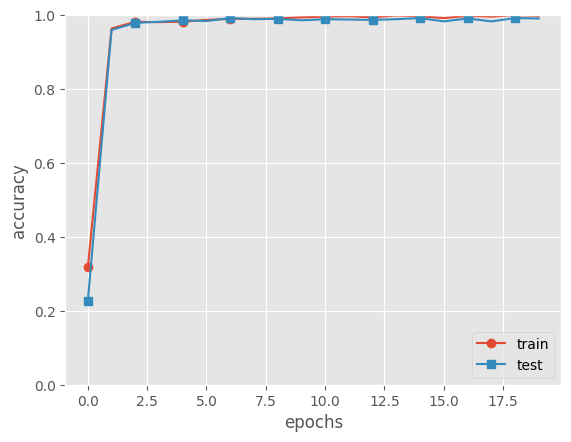

In [98]:
import numpy as np
import matplotlib.pyplot as plt
from utils.mnist import load_mnist
from utils.simple_convnet import SimpleConvNet
from utils.trainer import Trainer


plt.style.use('ggplot')

# データの読み込み
(x_train, t_train), (x_test, t_test) = load_mnist(flatten=False)

# 処理に時間のかかる場合はデータを削減 
# x_train, t_train = x_train[:5000], t_train[:5000]
# x_test, t_test = x_test[:1000], t_test[:1000]

max_epochs = 20

network = SimpleConvNet(input_dim=(1,28,28), 
                        conv_param = {'filter_num': 30, 'filter_size': 5, 'pad': 0, 'stride': 1},
                        hidden_size=100, output_size=10, weight_init_std=0.01)
                        
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=max_epochs, mini_batch_size=100,
                  optimizer='Adam', optimizer_param={'lr': 0.001},
                  evaluate_sample_num_per_epoch=1000)
trainer.train()

# パラメータの保存
network.save_params("params.pkl")
print("Saved Network Parameters!")

# グラフの描画
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, trainer.train_acc_list, marker='o', label='train', markevery=2)
plt.plot(x, trainer.test_acc_list, marker='s', label='test', markevery=2)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

結果として訓練識別率99.99%，テスト識別率98.97%となるようです．

かなり早い段階で学習がうまく行っているようなのでバッチサイズは減らせそうですね．

## CNNの可視化
畳み込み層は”何を見ている"のでしょうか？

畳み込みとは，そもそも相関を表す指標です．今回の場合では，入力とカーネルとの似ている具合を抽出していることになります．

以下では，先程の学習に関する畳み込みのフィルターを画像として表示してみましょう．

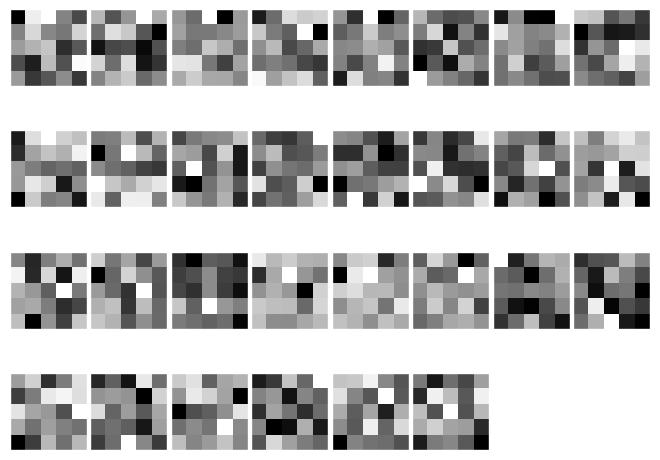

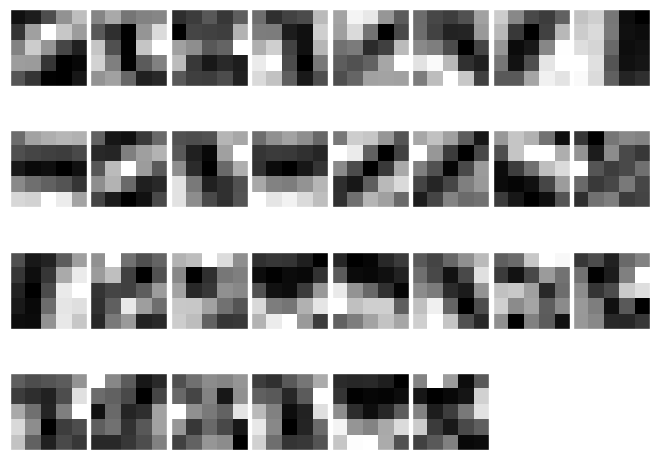

In [100]:
import numpy as np
import matplotlib.pyplot as plt
from utils.simple_convnet import SimpleConvNet

def filter_show(filters, nx=8, margin=3, scale=10):
    """
    c.f. https://gist.github.com/aidiary/07d530d5e08011832b12#file-draw_weight-py
    """
    FN, C, FH, FW = filters.shape
    ny = int(np.ceil(FN / nx))

    fig = plt.figure()
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

    for i in range(FN):
        ax = fig.add_subplot(ny, nx, i+1, xticks=[], yticks=[])
        ax.imshow(filters[i, 0], cmap=plt.cm.gray_r, interpolation='nearest')
    plt.show()


network = SimpleConvNet()
# ランダム初期化後の重み
filter_show(network.params['W1'])

# 学習後の重み
network.load_params("params.pkl")
filter_show(network.params['W1'])

上が学習前で，下が学習後です．

学習後は学習前に比べてある程度の規則性が現れているのが見て取れます．

このようなフィルターが見ているものとは「エッジ」や「ブロブ」と呼ばれるものです．

エッジとは，色が変化する境目であり，ブロブとは，局所的に塊がある領域です．

たとえば，左が白で右が黒である場合には，縦方向のエッジに反応するフィルターになります．（教科書図7-25）

## 代表的なCNN
この資料の最後にこれまでの歴史上で有名なCNNについて紹介します．

### LeNet
LeNet5の原著論文：
http://vision.stanford.edu/cs598_spring07/papers/Lecun98.pdf

わかりやすい動画：
https://www.youtube.com/watch?v=-tWolA2WvFI

畳み込み，平均プーリング．畳み込み，平均プーリング，全結合，全結合という流れのニューラルネットワークです．

### AlexNet
原著論文：
https://proceedings.neurips.cc/paper_files/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf

わかりやすい動画：
https://www.youtube.com/watch?v=KebUnMbOGU8

第3次AIブームの火付け役

畳み込み層とプーリング層の繰り返しが8回，全結合3回という流れのニューラルネット